In [1]:
import importlib
import os
import folium
import xarray as xr
import pandas as pd

import geopandas as gpd
import paths
from apollo import hydropoint

Baseline correlation of Flow vs Rain-3: 0.31


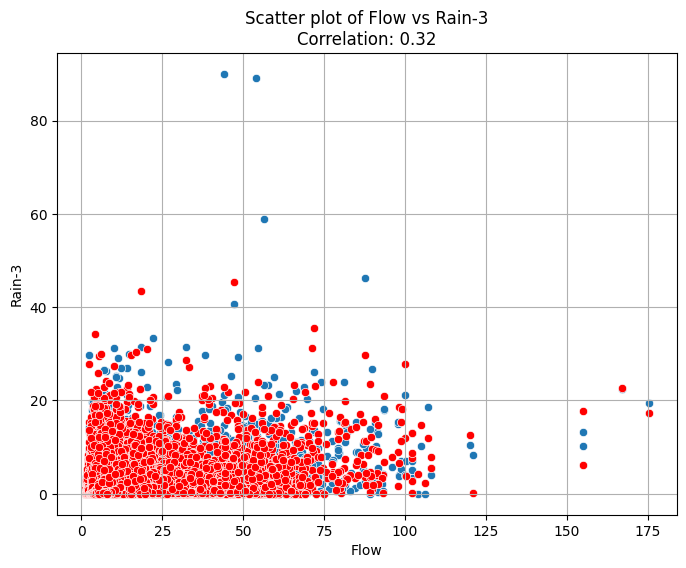

In [77]:
import seaborn as sns

rf_9to9_modified = rf_9to9[~pd.to_datetime(rf_9to9['Date']).dt.year.isin([2000])]

def plot_correlation(df, value, baseline=None):

    corr_value = df['Flow'].corr(df[value])

    plt.figure(figsize=(8, 6))
    sns.scatterplot(x='Flow', y=value, data=df)
    if baseline is not None:
        sns.scatterplot(x='Flow', y=value, data=baseline, color='red')
        baseline_corr_value = baseline['Flow'].corr(baseline[value])
        print(f'Baseline correlation of Flow vs {value}: {baseline_corr_value:.2f}')
    plt.title(f'Scatter plot of Flow vs {value}\nCorrelation: {corr_value:.2f}')
    plt.xlabel('Flow')
    plt.ylabel(value)
    plt.grid(True)
    plt.show()
    
plot_correlation(rf_9to9_modified, 'Rain-3', rf)

In [3]:
import pandas as pd

def get_flow_df(station):
    flow = pd.read_csv(paths.CATCHMENT_BASINS + f'/{station}/{station}_gdf.csv')
    flow = flow.drop(flow.columns[2], axis=1)
    flow = flow.drop(flow.index[0:19])
    flow.columns = ['Date', 'Flow']
    flow['Date'] = pd.to_datetime(flow['Date'])
    flow['Flow'] = flow['Flow'].astype('Float64')
    return flow

In [130]:
stations =  [7001, 33039, 33035, 54057]
results = {}

for station in stations:
    flow = get_flow_df(station)
    flow['Date'] = pd.to_datetime(flow['Date'])  # Ensure the 'Date' column is in datetime format

    # Create an empty dictionary to store yearly sums for this station
    yearly_sums = {}

    # Iterate over the years from 1972 to 2022
    for year in range(1979, 2023):
        yearly_sum = flow[flow['Date'].dt.year == year]['Flow'].sum()
        yearly_sums[year] = yearly_sum

    # Add the yearly sums to the results dictionary with the station ID as the key
    results[station] = yearly_sums

# Convert the results dictionary to a DataFrame
yearly_flow_df = pd.DataFrame(results).transpose()

# Reset the index to have the station IDs as a column
yearly_flow_df.reset_index(inplace=True)
yearly_flow_df.rename(columns={'index': 'Station'}, inplace=True)
yearly_flow_df

,Station,1979,1980,1981,1982,1983,1984,1985,1986,1987,...,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
0,7001,5806.108,5276.671,5581.894,6341.172,5882.326,5275.659,5731.37,5355.042,4781.812,...,3981.591,5425.517,6558.722,4529.922,4503.240,3482.936,5373.412,6174.710,5021.921,2859.723
1,33039,6020.960,4706.960,4574.960,4794.400,4077.120,3844.350,3551.91,4585.640,5081.010,...,4867.570,5908.760,2873.640,3923.660,2933.080,3918.415,3480.227,5327.619,4804.184,1856.976
2,33035,7816.300,5659.200,6582.200,6481.200,6735.100,5897.800,5744.60,4824.400,8755.600,...,5829.412,7244.600,5652.703,5933.816,3581.052,5002.296,2840.519,6407.158,6195.045,0.000
3,54057,47591.900,45643.200,45549.500,48345.900,40126.300,39025.300,37959.20,43957.860,41459.700,...,45698.100,55213.200,36269.800,43330.400,30308.800,42219.000,55970.380,48323.620,45223.620,23224.880


In [131]:
rescaled_df = yearly_flow_df.copy()
rescaled_df.iloc[:, 1:] = rescaled_df.iloc[:, 1:].div(rescaled_df.iloc[:, 1:].max(axis=1), axis=0)
rescaled_df

,Station,1979,1980,1981,1982,1983,1984,1985,1986,1987,...,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
0,7001,0.832239,0.756351,0.800101,0.908935,0.843164,0.756205,0.821526,0.767584,0.685418,...,0.570716,0.777686,0.940118,0.649313,0.645488,0.499239,0.770217,0.885074,0.719835,0.409909
1,33039,0.903948,0.706672,0.686855,0.719800,0.612112,0.577166,0.533261,0.688458,0.762830,...,0.730785,0.887103,0.431430,0.589073,0.440353,0.588285,0.522499,0.799854,0.721269,0.278794
2,33035,0.766898,0.555254,0.645814,0.635904,0.660816,0.578664,0.563633,0.473347,0.859058,...,0.571954,0.710805,0.554616,0.582198,0.351356,0.490801,0.278698,0.628640,0.607828,0.000000
3,54057,0.772516,0.740884,0.739363,0.784755,0.651333,0.633462,0.616157,0.713527,0.672977,...,0.741775,0.896225,0.588734,0.703343,0.491975,0.685302,0.908516,0.784393,0.734073,0.376988


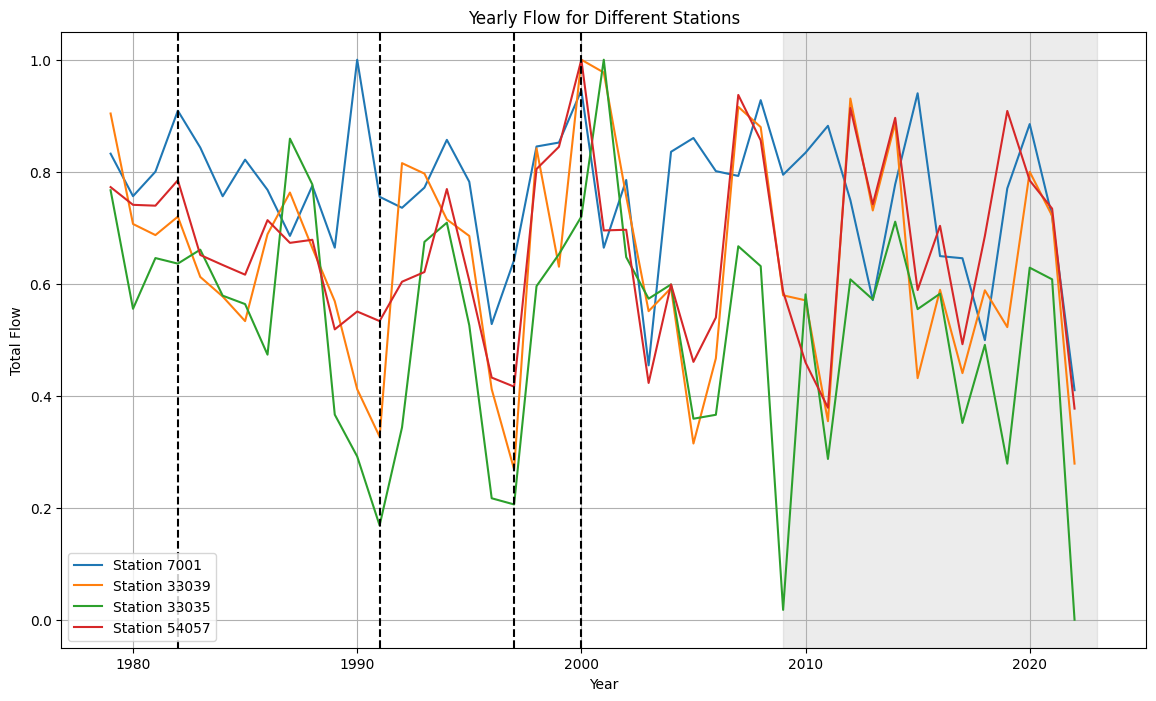

In [164]:
import matplotlib.pyplot as plt
plt.figure(figsize=(14, 8))

# Iterate over each station to plot its data
for station in stations:
    plt.plot(rescaled_df.columns[1:], rescaled_df.loc[rescaled_df['Station'] == station].values.flatten()[1:], label=f'Station {station}')

plt.axvline(x = 1982, linestyle='--', color='black')
plt.axvline(x = 1991, linestyle='--', color='black')
plt.axvline(x = 1997, linestyle='--', color='black')
plt.axvline(x = 2000, linestyle='--', color='black')

# Define the date from which onwards the area should be shaded
highlight_start_date = 2009
plt.axvspan(highlight_start_date, 2023, color='grey', alpha=0.15)

# Add titles and labels
plt.title('Yearly Flow for Different Stations')
plt.xlabel('Year')
plt.ylabel('Total Flow')
plt.legend()
plt.grid(True)

# Display the plot
plt.show()

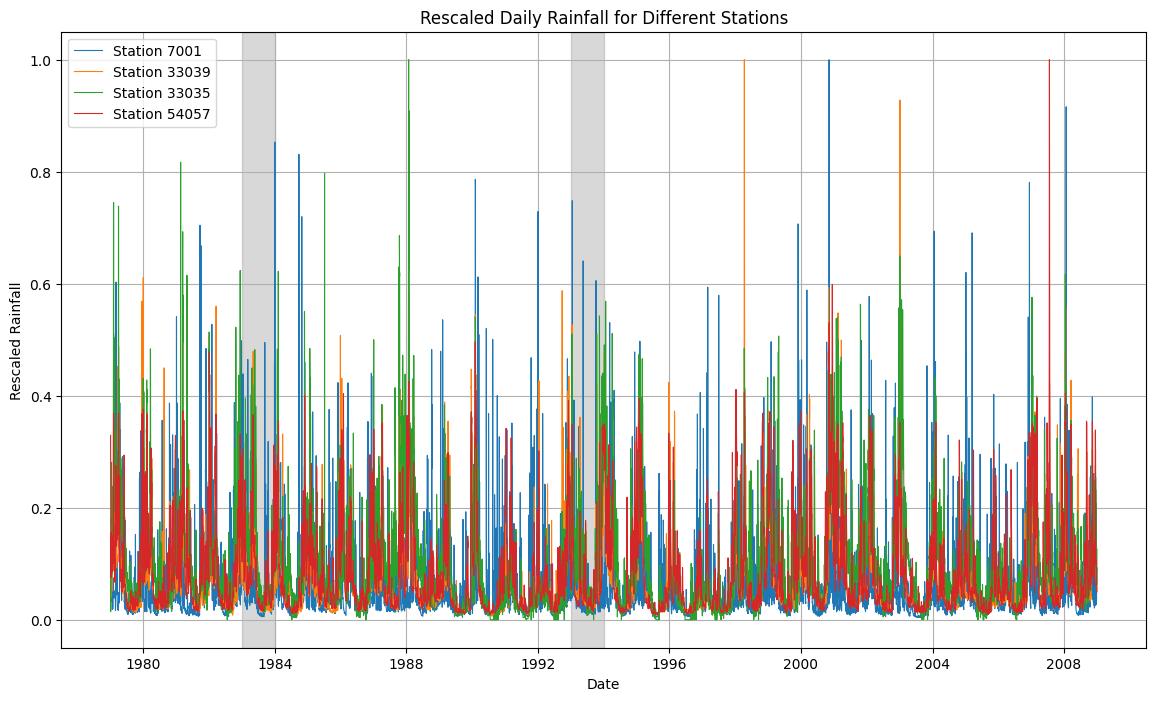

In [156]:
results = {}

# Iterate over each station
for station in stations:
    rain = get_flow_df(station)
    rain['Date'] = pd.to_datetime(rain['Date']) 
    
    rain = rain[rain['Date'] >= '1979-01-01']
    rain = rain[rain['Date']  <= '2009-01-01']
    
    rain['Rescaled_Flow'] = rain['Flow'] / rain['Flow'].max()
    results[station] = rain.set_index('Date')['Rescaled_Flow']

rescaled_flow_df = pd.DataFrame(results)

plt.figure(figsize=(14, 8))

# Iterate over each station to plot its rescaled data
for station in stations:
    plt.plot(rescaled_flow_df.index, rescaled_flow_df[station], label=f'Station {station}', linewidth=0.8)
    
highlight_years = ['1983', '1993']
for year in highlight_years:
    plt.axvspan(f'{year}-01-01', f'{year}-12-31', color='grey', alpha=0.3)

# Add titles and labels
plt.title('Rescaled Daily Rainfall for Different Stations')
plt.xlabel('Date')
plt.ylabel('Rescaled Rainfall')
plt.legend()
plt.grid(True)

# Display the plot
plt.show()

In [ ]:
import branca.colormap as cm
from apollo import osgconv as osg

center = [55, -0.5]

lat_start, lat_end, lat_step = 60, 48, -0.25
lon_start, lon_end, lon_step = -8, 4, 0.25

m = folium.Map(location=center, zoom_start=5.5)  
folium.TileLayer('CartoDB Positron No Labels').add_to(m)

colormap = cm.linear.viridis.scale(51.10, 57.74)

# Reorganize order such that specific catchments get plotted on top
catchments_specific = ['7001', '33039', '54057']
all_catchments = os.listdir('../' + paths.CATCHMENT_BASINS)
all_catchments = [c for c in all_catchments if c not in catchments_specific] + catchments_specific

for catchment_nr in all_catchments: 
    
    gdf = gpd.read_file('../' + paths.CATCHMENT_BASINS + '/' + catchment_nr + '/' + catchment_nr + '.shp')
    gdf = gdf.to_crs("EPSG:4326")
    points = gdf.centroid
    lat = points.y[0]

    color = colormap(lat)   
    style_function=lambda x: {'fillColor': color, 'color': color, 'weight': 2, 'fillOpacity': 0.8}
   
    layer = folium.GeoJson(
        gdf,
        name=catchment_nr,
        style_function=style_function
    ).add_to(m)
    
folium.LayerControl().add_to(m)
m